# Project 1 on Machine Learning

## Regression Analysis and Resamping methods

### Part a : Ordinary Least Square (OLS) for the Runge function

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def runge_function(x):
    return 1/ (1 + 25 * x**2)

def runge_noisy(x, noise = 0.1):
    return runge_function(x) + np.random.normal(0, noise, size = x.shape)

In [5]:
n_points = 100
x = np.linspace(-1, 1, n_points).reshape(-1, 1)

y_true = runge_function(x).ravel()

y = runge_noisy(x, noise = 0.1).ravel()

def design_matrix(x, degree):
    X = np.ones((x.shape[0], 1))
    for d in range(1, degree+1):
        X = np.hstack((X, x**d))
    return X

def ols_fit(X, y):
    beta = np.linalg.pinv(X.T @ X) @ X.T @ y
    return beta

def predict(X, beta):
    return X @ beta

Text(0.5, 1.0, 'R² vs Polynomial Degree')

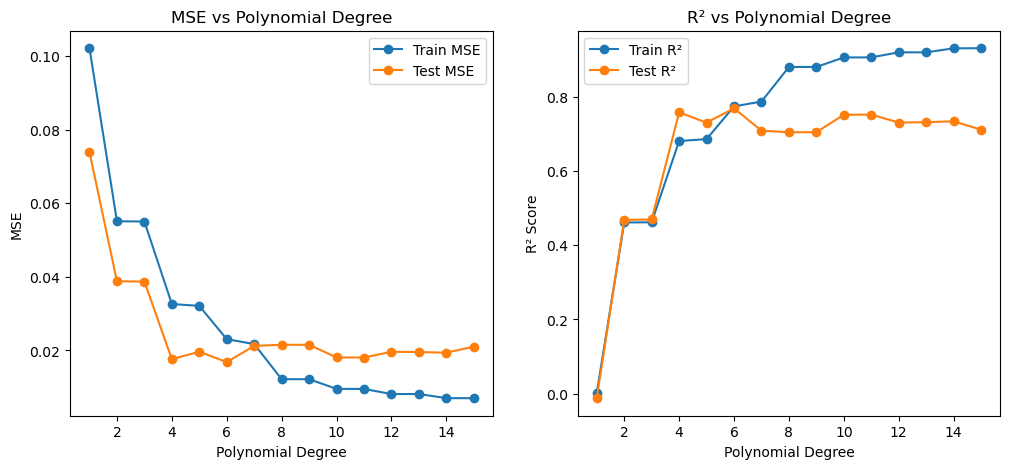

In [6]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def r2_value(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

degrees = range(1, 16)
mse_train, mse_test, r2_train, r2_test = [], [], [], []

for d in degrees:
    X_train = design_matrix(x_train_scaled, d)
    X_test = design_matrix(x_test_scaled, d)
    
    beta = ols_fit(X_train, y_train)
    
    y_train_pred = predict(X_train, beta)
    y_test_pred = predict(X_test, beta)
    
    mse_train.append(mse(y_train, y_train_pred))
    mse_test.append(mse(y_test, y_test_pred))
    r2_train.append(r2_value(y_train, y_train_pred))
    r2_test.append(r2_value(y_test, y_test_pred))
    
plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.plot(degrees, mse_train, 'o-', label = "Train MSE")
plt.plot(degrees, mse_test, 'o-', label = "Test MSE")
plt.xlabel("Polynomial Degree")
plt.ylabel("MSE")
plt.legend()
plt.title("MSE vs Polynomial Degree")

plt.subplot(1, 2, 2)
plt.plot(degrees, r2_train, 'o-', label = "Train R²")
plt.plot(degrees, r2_test, 'o-', label = "Test R²")
plt.xlabel("Polynomial Degree")
plt.ylabel("R² Score")
plt.legend()
plt.title("R² vs Polynomial Degree")


Data scaling is particularly important when working with high-degree polynomials, since their values can grow exponentially. In order to address this, we applied StandardScaler to x in our code. When x lies between −1 and 1, higher powers do not change its value significantly. However, after performing a train-test split, differences in scale and noise may arise. Scaling ensures that all features remain on a comparable range. This step becomes even more critical for regularisation methods, which we will discuss later, because their penalty terms are directly influenced by feature magnitudes.

### Part b: Adding Ridge regression for the Runge function

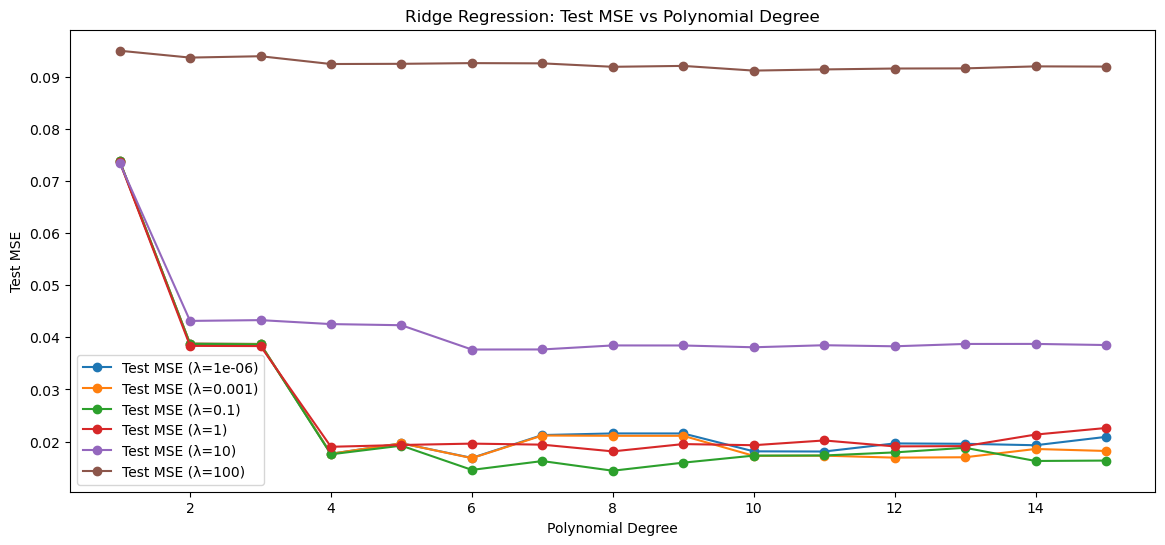

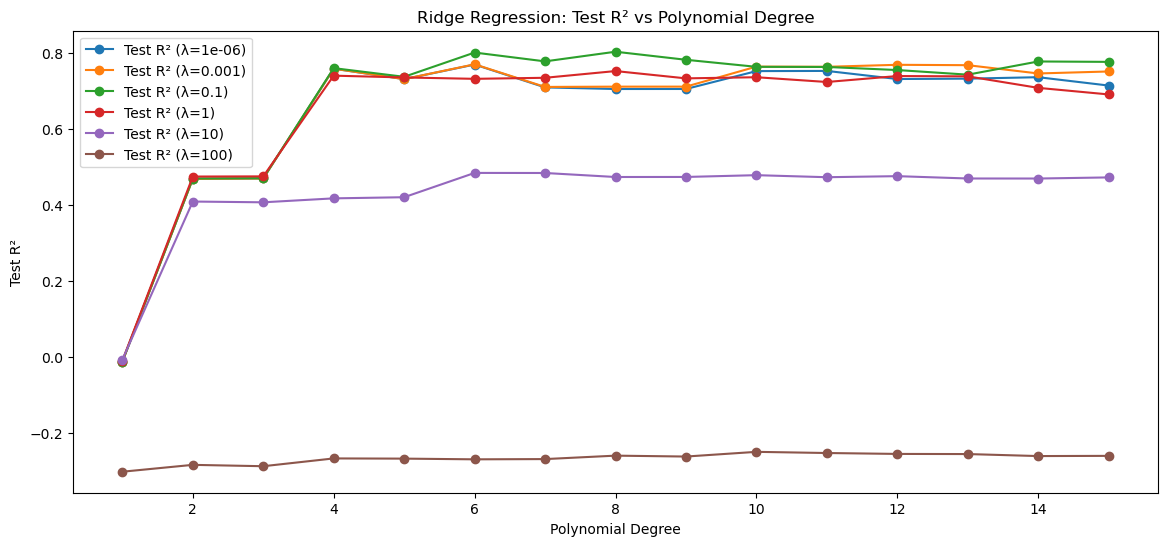

In [7]:
def ridge_reg(X, y, lam):
    n_features = X.shape[1]
    I = np.eye(n_features)
    beta = np.linalg.pinv(X.T @ X + lam * I) @ X.T @ y
    return beta

degrees = range(1, 16)
lambdas = [1e-6, 1e-3, 1e-1, 1, 10, 100]

results = {}

for lam in lambdas:
    mse_train, mse_test, r2_train, r2_test = [], [], [], []
    
    for d in degrees:
        X_train = design_matrix(x_train_scaled, d)
        X_test = design_matrix(x_test_scaled, d)
        
        beta = ridge_reg(X_train, y_train, lam)
        y_train_pred = predict(X_train, beta)
        y_test_pred = predict(X_test, beta)
        
        mse_train.append(mse(y_train, y_train_pred))
        mse_test.append(mse(y_test, y_test_pred))
        r2_train.append(r2_value(y_train, y_train_pred))
        r2_test.append(r2_value(y_test, y_test_pred))
        
    results[lam] = {
        "mse_train": mse_train,
        "mse_test": mse_test,
        "r2_train": r2_train,
        'r2_test': r2_test
    }
    
plt.figure(figsize = (14, 6))

for lam in lambdas:
    plt.plot(degrees, results[lam]["mse_test"], 'o-', label = f"Test MSE (λ={lam})")

plt.xlabel("Polynomial Degree")
plt.ylabel("Test MSE")
plt.title("Ridge Regression: Test MSE vs Polynomial Degree")
plt.legend()
plt.show()

plt.figure(figsize = (14, 6))
for lam in lambdas:
    plt.plot(degrees, results[lam]["r2_test"], 'o-', label = f"Test R² (λ={lam})")
    
plt.xlabel("Polynomial Degree")
plt.ylabel("Test R²")
plt.title("Ridge Regression: Test R² vs Polynomial Degree")
plt.legend()
plt.show()
    

When lambda = 0, ridge regression produces results equivalent to OLS. For very small values of lambda (e.g., 
1e−6, 1e−3), the results remain similar to OLS, but with slightly greater stability at higher polynomial degrees. With moderate values of lambda (e.g., 0.1, 1), ridge regression reduces variance, leading to less overfitting and lower error compared to OLS. However, for large values of lambda (e.g., 10, 100), underfitting occurs: R² decreases and test MSE increases. This behavior illustrates the bias–variance tradeoff: while OLS tends to overfit at high polynomial degrees, ridge regression stabilises solutions by penalising large coefficients.

### Part c: Forming Gradient Descent

In [8]:
def gd_ols_fixed(X, y, gamma=1e-3, max_iters=200000, grad_tol=1e-8, theta0=None):
    n, p = X.shape
    theta = np.random.randn(p) if theta0 is None else theta0.copy()

    history = {"loss": [], "grad_norm": []}

    for _ in range(max_iters):
        # gradient and loss
        r = X @ theta - y                           # residuals
        grad = (2.0 / n) * (X.T @ r)                # gradient C(theta)
        grad_norm = np.linalg.norm(grad)
        loss = (r @ r) / n                          # C(theta)

        history["loss"].append(loss)
        history["grad_norm"].append(grad_norm)

        if grad_norm <= grad_tol:                   # early stop criteria
            break

        # update
        theta = theta - gamma * grad

    return theta, history

comments: implementation of simple GD with fixed learning rate $\gamma$

/var/folders/z5/_s6rzfqj5ybby8jy3p7kx12w0000gn/T/ipykernel_31113/105864795.py:12: RuntimeWarning: overflow encountered in matmul
  loss = (r @ r) / n                          # C(theta)
/var/folders/z5/_s6rzfqj5ybby8jy3p7kx12w0000gn/T/ipykernel_31113/105864795.py:10: RuntimeWarning: overflow encountered in matmul
  grad = (2.0 / n) * (X.T @ r)                # gradient C(theta)
/var/folders/z5/_s6rzfqj5ybby8jy3p7kx12w0000gn/T/ipykernel_31113/105864795.py:10: RuntimeWarning: invalid value encountered in matmul
  grad = (2.0 / n) * (X.T @ r)                # gradient C(theta)
/var/folders/z5/_s6rzfqj5ybby8jy3p7kx12w0000gn/T/ipykernel_31113/105864795.py:21: RuntimeWarning: invalid value encountered in subtract
  theta = theta - gamma * grad
/var/folders/z5/_s6rzfqj5ybby8jy3p7kx12w0000gn/T/ipykernel_31113/105864795.py:9: RuntimeWarning: invalid value encountered in matmul
  r = X @ theta - y                           # residuals


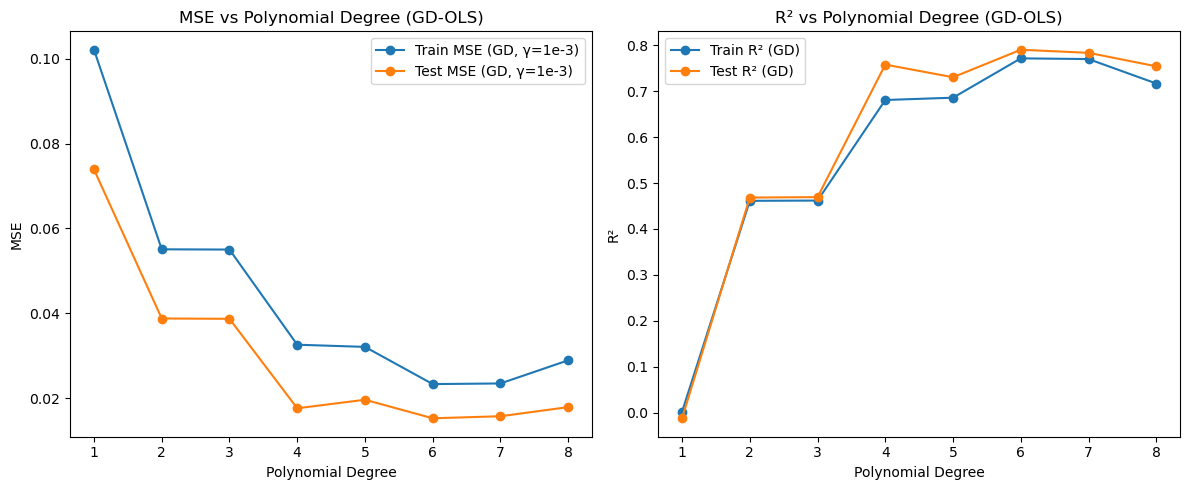

In [9]:
degrees = range(1, 16)
gamma = 1e-3          # constant learning rate
grad_tol = 1e-8

mse_train_gd, mse_test_gd, r2_train_gd, r2_test_gd = [], [], [], []

for d in degrees:
    X_train = design_matrix(x_train_scaled, d)
    X_test  = design_matrix(x_test_scaled,  d)

    beta_gd, hist = gd_ols_fixed(X_train, y_train, gamma=gamma, grad_tol=grad_tol)

    ytr_hat = predict(X_train, beta_gd)
    yte_hat = predict(X_test,  beta_gd)

    mse_train_gd.append(mse(y_train, ytr_hat))
    mse_test_gd.append(mse(y_test,  yte_hat))
    r2_train_gd.append(r2_value(y_train, ytr_hat))
    r2_test_gd.append(r2_value(y_test,  yte_hat))

# plots for Part (c)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(degrees, mse_train_gd, 'o-', label='Train MSE (GD, γ=1e-3)')
plt.plot(degrees, mse_test_gd,  'o-', label='Test MSE (GD, γ=1e-3)')
plt.xlabel("Polynomial Degree"); plt.ylabel("MSE"); plt.title("MSE vs Polynomial Degree (GD-OLS)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(degrees, r2_train_gd, 'o-', label='Train R² (GD)')
plt.plot(degrees, r2_test_gd,  'o-', label='Test R² (GD)')
plt.xlabel("Polynomial Degree"); plt.ylabel("R²"); plt.title("R² vs Polynomial Degree (GD-OLS)")
plt.legend(); plt.tight_layout(); plt.show()


comment: repeat of parts a and b. MSE and R^2 of each poly degree

In part c, we replaced the analytic solution of OLS with our own GD implementation with a fixed learning rate $\gamma$. The graphs plotted, namely MSE and R^2 against polynomial degree shows that the GD-based OLS generally produces the same trend as in that in part a. MSE and R^2 decreases adn increases respectively with polynomial degree. Convergence was achieved up to degree 8, after which, GD with $\gamma$ = 10^-3 did not converge reliably within the iteration budget. This highlights the sensitivity of GD to both learning rate and polynomial degree, as higher-degree design matrices amplify instability.

/var/folders/z5/_s6rzfqj5ybby8jy3p7kx12w0000gn/T/ipykernel_31113/105864795.py:12: RuntimeWarning: overflow encountered in matmul
  loss = (r @ r) / n                          # C(theta)
/var/folders/z5/_s6rzfqj5ybby8jy3p7kx12w0000gn/T/ipykernel_31113/105864795.py:10: RuntimeWarning: overflow encountered in matmul
  grad = (2.0 / n) * (X.T @ r)                # gradient C(theta)
/var/folders/z5/_s6rzfqj5ybby8jy3p7kx12w0000gn/T/ipykernel_31113/105864795.py:10: RuntimeWarning: invalid value encountered in matmul
  grad = (2.0 / n) * (X.T @ r)                # gradient C(theta)
/var/folders/z5/_s6rzfqj5ybby8jy3p7kx12w0000gn/T/ipykernel_31113/105864795.py:21: RuntimeWarning: invalid value encountered in subtract
  theta = theta - gamma * grad


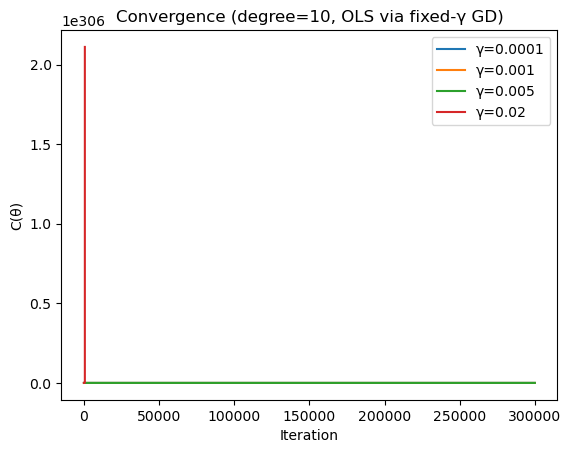

In [10]:
d = 6
Xtr = design_matrix(x_train_scaled, d)

for g in [1e-4, 1e-3, 5e-3, 2e-2]:
    _, h = gd_ols_fixed(Xtr, y_train, gamma=g, grad_tol=1e-10, max_iters=300000)
    plt.plot(h["loss"], label=f"γ={g}")
plt.xlabel("Iteration"); plt.ylabel("C(θ)"); plt.title("Convergence (degree=10, OLS via fixed-γ GD)")
plt.legend(); plt.show()


comments: convergence plot 

Figure Y illustrates the convergence behavior for different learning rates at degree 10. With small γ values (blue, yellow and green line), the algorithm converges steadily, though the speed varies. At $\gamma$ = 10^-3, the yellow line, GD converges efficiently to a solution comparable to the closed-form OLS, confirming that GD can approximate the analytic optimum when tuned appropriately. However, at $\gamma$ = 0.02 the updates overshoot, causing the cost function to diverge immediately to extremely large values, dominating the plot.

These results underline that while GD provides a flexible, iterative alternative to the analytic OLS solution, its success depends critically on the choice of learning rate. Too small a $\gamma$ leads to slow convergence, while too large a $\gamma$ causes divergence. The inability to stably reach solutions at higher polynomial degrees further emphasizes this sensitivity, motivating the use of more advanced optimizers with momentum or adaptive learning rates, as explored in Part (d).

### Part d: Using momentum, ADAgrad, RMSprop and ADAM to update learning rate

#### Momentum

In [11]:
def momentum_sgd_ols_ridge(
    X, y,
    eta=1e-2,          # step size (γ)
    mu=0.9,            # momentum coefficient
    n_epochs=50,
    batch_size=5,
    lam=0.0,           # 0 -> OLS, >0 -> Ridge
    regularize_bias=False,
    shuffle=True,
    theta0=None,
    rng=np.random
):
    n, p = X.shape
    theta = rng.randn(p) if theta0 is None else theta0.copy()
    history = {"loss_per_epoch": [], "theta": []}

    def batch_grad(Xb, yb, theta):
        M = Xb.shape[0]
        g = (2.0 / M) * (Xb.T @ (Xb @ theta - yb))
        if lam != 0:
            if regularize_bias: g += 2.0 * lam * theta
            else:               g[1:] += 2.0 * lam * theta[1:]
        return g

    v = np.zeros_like(theta)
    for _ in range(n_epochs):
        if shuffle:
            idx = rng.permutation(n)
            X_sh, y_sh = X[idx], y[idx]
        else:
            X_sh, y_sh = X, y

        for s in range(0, n, batch_size):
            e = min(s + batch_size, n)
            Xb, yb = X_sh[s:e], y_sh[s:e]
            g = batch_grad(Xb, yb, theta)
            v = mu * v + eta * g
            theta -= v

        resid = y - X @ theta
        loss = resid @ resid + (0 if lam == 0 else (lam * (theta @ theta if regularize_bias else theta[1:] @ theta[1:])))
        history["loss_per_epoch"].append(loss)
        history["theta"].append(theta.copy())
    return theta, history


#### AdaGrad

In [12]:
def adagrad_sgd_ols_ridge(
    X, y,
    eta=1e-2,          # learning rate (ε in the slide)
    delta=1e-8,        # small constant to avoid division by zero
    n_epochs=50,
    batch_size=32,     # M; set to X.shape[0] for full batch
    lam=0.0,           # 0 -> OLS, >0 -> Ridge penalty
    regularize_bias=False,
    shuffle=True,
    theta0=None,
    rng=np.random
):
    n, p = X.shape
    theta = rng.randn(p) if theta0 is None else theta0.copy()

    def batch_grad(Xb, yb, theta):
        # gradient of sum-of-squares: ∂/∂θ ∑ (yb - Xbθ)^2 = -2 Xb^T (yb - Xbθ)
        # divide by M 
        M = Xb.shape[0]
        g = (2.0 / M) * (Xb.T @ (Xb @ theta - yb))
        if lam != 0:
            if regularize_bias:
                g += 2.0 * lam * theta
            else:
                g[1:] += 2.0 * lam * theta[1:]
        return g

    history = {"loss_per_epoch": [], "theta": []}

    for _ in range(n_epochs):
        # reset accumulator each epoch (lecturer's code does this)
        Giter = np.zeros_like(theta)

        # optional shuffle
        if shuffle:
            idx = rng.permutation(n)
            X_sh, y_sh = X[idx], y[idx]
        else:
            X_sh, y_sh = X, y

        # iterate mini-batches
        for start in range(0, n, batch_size):
            stop = min(start + batch_size, n)
            Xb, yb = X_sh[start:stop], y_sh[start:stop]

            g = batch_grad(Xb, yb, theta)
            Giter += g * g
            step = (eta / (delta + np.sqrt(Giter))) * g
            theta -= step

        # track epoch loss (on full data; sum-of-squares to match snippet)
        resid = y - X @ theta
        loss = resid @ resid + (0.0 if lam == 0 else
               (lam * (theta @ theta if regularize_bias else theta[1:] @ theta[1:])))
        history["loss_per_epoch"].append(loss)
        history["theta"].append(theta.copy())

    return theta, history


#### RMSProp

In [13]:
def rmsprop_sgd_ols_ridge(
    X, y,
    eta=1e-2,          # learning rate
    rho=0.99,          # decay for squared-grad moving average
    delta=1e-8,        # numerical stability
    n_epochs=50,
    batch_size=5,      # M in the lecturer’s code; set to X.shape[0] for full-batch
    lam=0.0,           # 0 -> OLS, >0 -> Ridge
    regularize_bias=False,
    shuffle=True,
    theta0=None,
    rng=np.random
):
    n, p = X.shape
    theta = rng.randn(p) if theta0 is None else theta0.copy()

    def batch_grad(Xb, yb, theta):
        # grad of ∑(yb - Xbθ)^2 w.r.t θ, scaled by 1/M to match snippet
        M = Xb.shape[0]
        g = (2.0 / M) * (Xb.T @ (Xb @ theta - yb))
        if lam != 0:
            if regularize_bias:
                g += 2.0 * lam * theta
            else:
                g[1:] += 2.0 * lam * theta[1:]
        return g

    history = {"loss_per_epoch": [], "theta": []}

    for _ in range(n_epochs):
        # initialize moving average (vector) at the start of each epoch
        Giter = np.zeros_like(theta)

        if shuffle:
            idx = rng.permutation(n)
            X_sh, y_sh = X[idx], y[idx]
        else:
            X_sh, y_sh = X, y

        for start in range(0, n, batch_size):
            stop = min(start + batch_size, n)
            Xb, yb = X_sh[start:stop], y_sh[start:stop]

            g = batch_grad(Xb, yb, theta)
            Giter = rho * Giter + (1.0 - rho) * (g * g)              # EMA of squared grads
            step  = (eta / (delta + np.sqrt(Giter))) * g              # element-wise scaling
            theta -= step

        # track epoch loss on full data (sum-of-squares to mirror snippet)
        resid = y - X @ theta
        loss = resid @ resid + (0.0 if lam == 0 else
               (lam * (theta @ theta if regularize_bias else theta[1:] @ theta[1:])))
        history["loss_per_epoch"].append(loss)
        history["theta"].append(theta.copy())

    return theta, history


#### ADAM

In [14]:
def adam_sgd_ols_ridge(
    X, y,
    eta=1e-2,          # learning rate
    beta1=0.9,         # theta1 
    beta2=0.999,       # theta2 
    delta=1e-7,        # numerical stability
    n_epochs=50,
    batch_size=5,      # M 
    lam=0.0,           # 0 -> OLS, >0 -> Ridge
    regularize_bias=False,
    shuffle=True,
    theta0=None,
    rng=np.random
):
    n, p = X.shape
    theta = rng.randn(p) if theta0 is None else theta0.copy()

    def batch_grad(Xb, yb, theta):
        # gradient of sum-of-squares, scaled by 1/M to mirror snippet
        M = Xb.shape[0]
        g = (2.0 / M) * (Xb.T @ (Xb @ theta - yb))
        if lam != 0:
            if regularize_bias:
                g += 2.0 * lam * theta
            else:
                g[1:] += 2.0 * lam * theta[1:]
        return g

    history = {"loss_per_epoch": [], "theta": []}
    iter_t = 0  # increments once per epoch (matches the provided code)

    for _ in range(n_epochs):
        # reset moments each epoch (as in the snippet)
        m = np.zeros_like(theta)
        v = np.zeros_like(theta)
        iter_t += 1

        if shuffle:
            idx = rng.permutation(n)
            X_sh, y_sh = X[idx], y[idx]
        else:
            X_sh, y_sh = X, y

        for start in range(0, n, batch_size):
            stop = min(start + batch_size, n)
            Xb, yb = X_sh[start:stop], y_sh[start:stop]

            g = batch_grad(Xb, yb, theta)
            m = beta1 * m + (1.0 - beta1) * g
            v = beta2 * v + (1.0 - beta2) * (g * g)

            mhat = m / (1.0 - (beta1 ** iter_t))
            vhat = v / (1.0 - (beta2 ** iter_t))

            step = eta * mhat / (np.sqrt(vhat) + delta)
            theta -= step

        # track epoch loss on full data (sum-of-squares form)
        resid = y - X @ theta
        loss = resid @ resid + (0.0 if lam == 0 else
               (lam * (theta @ theta if regularize_bias else theta[1:] @ theta[1:])))
        history["loss_per_epoch"].append(loss)
        history["theta"].append(theta.copy())

    return theta, history


Next, we compare across the degrees for the 4 optimizers

/var/folders/z5/_s6rzfqj5ybby8jy3p7kx12w0000gn/T/ipykernel_31113/3116178561.py:41: RuntimeWarning: overflow encountered in matmul
  loss = resid @ resid + (0 if lam == 0 else (lam * (theta @ theta if regularize_bias else theta[1:] @ theta[1:])))
/var/folders/z5/_s6rzfqj5ybby8jy3p7kx12w0000gn/T/ipykernel_31113/833677920.py:2: RuntimeWarning: overflow encountered in square
  return np.mean((y_true - y_pred)**2)
/var/folders/z5/_s6rzfqj5ybby8jy3p7kx12w0000gn/T/ipykernel_31113/833677920.py:5: RuntimeWarning: overflow encountered in square
  return 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)


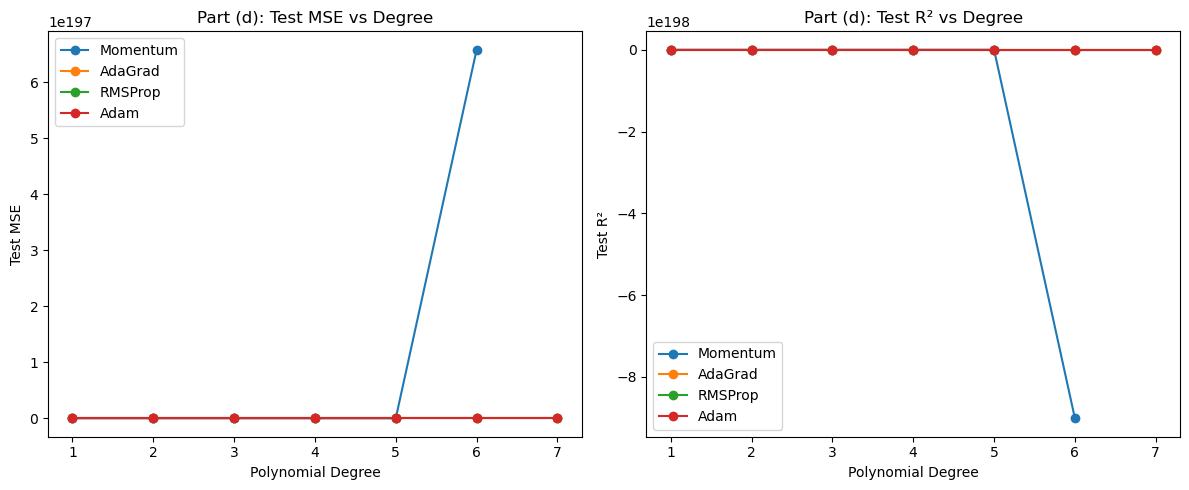

In [43]:
def run_part_d_compare_optimizers(
    degrees=range(1, 16),
    n_epochs=50, batch_size=5,
    eta_mom=1e-2, mu=0.9,
    eta_ada=1e-2, delta_ada=1e-8,
    eta_rms=1e-2, rho=0.99, delta_rms=1e-8,
    eta_adam=1e-2, beta1=0.9, beta2=0.999, delta_adam=1e-7,
    lam=0.0, regularize_bias=False
):
    results = { "Momentum": {"mse_test":[], "r2_test":[]},
                "AdaGrad":  {"mse_test":[], "r2_test":[]},
                "RMSProp":  {"mse_test":[], "r2_test":[]},
                "Adam":     {"mse_test":[], "r2_test":[]} }

    for d in degrees:
        Xtr = design_matrix(x_train_scaled, d)
        Xte = design_matrix(x_test_scaled,  d)

        # Momentum
        b_mom, _ = momentum_sgd_ols_ridge(
            Xtr, y_train, eta=eta_mom, mu=mu,
            n_epochs=n_epochs, batch_size=batch_size,
            lam=lam, regularize_bias=regularize_bias
        )
        yhat_tr = predict(Xtr, b_mom); yhat_te = predict(Xte, b_mom)
        results["Momentum"]["mse_test"].append(mse(y_test, yhat_te))
        results["Momentum"]["r2_test"].append(r2_value(y_test, yhat_te))

        # AdaGrad
        b_ada, _ = adagrad_sgd_ols_ridge(
            Xtr, y_train, eta=eta_ada, delta=delta_ada,
            n_epochs=n_epochs, batch_size=batch_size,
            lam=lam, regularize_bias=regularize_bias
        )
        yhat_te = predict(Xte, b_ada)
        results["AdaGrad"]["mse_test"].append(mse(y_test, yhat_te))
        results["AdaGrad"]["r2_test"].append(r2_value(y_test, yhat_te))

        # RMSProp
        b_rms, _ = rmsprop_sgd_ols_ridge(
            Xtr, y_train, eta=eta_rms, rho=rho, delta=delta_rms,
            n_epochs=n_epochs, batch_size=batch_size,
            lam=lam, regularize_bias=regularize_bias
        )
        yhat_te = predict(Xte, b_rms)
        results["RMSProp"]["mse_test"].append(mse(y_test, yhat_te))
        results["RMSProp"]["r2_test"].append(r2_value(y_test, yhat_te))

        # Adam
        b_adam, _ = adam_sgd_ols_ridge(
            Xtr, y_train, eta=eta_adam, beta1=beta1, beta2=beta2, delta=delta_adam,
            n_epochs=n_epochs, batch_size=batch_size,
            lam=lam, regularize_bias=regularize_bias
        )
        yhat_te = predict(Xte, b_adam)
        results["Adam"]["mse_test"].append(mse(y_test, yhat_te))
        results["Adam"]["r2_test"].append(r2_value(y_test, yhat_te))

    return results

# --- Run it ---
degrees = range(1, 8)
res_d = run_part_d_compare_optimizers(degrees=degrees)

# Plot Test MSE / Test R² vs Degree
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
for name in res_d:
    plt.plot(degrees, res_d[name]["mse_test"], 'o-', label=name)
plt.xlabel("Polynomial Degree"); plt.ylabel("Test MSE"); plt.title("Part (d): Test MSE vs Degree")
plt.legend()

plt.subplot(1,2,2)
for name in res_d:
    plt.plot(degrees, res_d[name]["r2_test"], 'o-', label=name)
plt.xlabel("Polynomial Degree"); plt.ylabel("Test R²"); plt.title("Part (d): Test R² vs Degree")
plt.legend()
plt.tight_layout(); plt.show()


We remove momentum to observe in greater detail of the remaining optimizers

captions: 
Figure X (Test MSE and R^2 vs Polynomial Degree, all methods):
Momentum diverges at higher degrees, producing extremely large MSE and negative R^2, while the adaptive methods remain numerically stable.

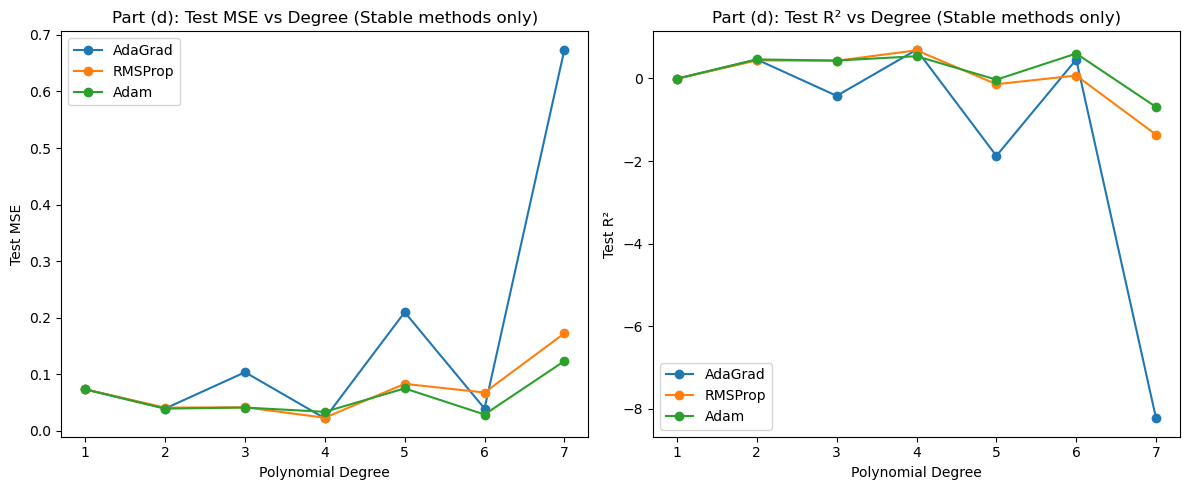

In [44]:
# --- only stable methods (AdaGrad, RMSProp, Adam) ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
for name in ["AdaGrad", "RMSProp", "Adam"]:
    plt.plot(degrees, res_d[name]["mse_test"], 'o-', label=name)
plt.xlabel("Polynomial Degree"); plt.ylabel("Test MSE")
plt.title("Part (d): Test MSE vs Degree (Stable methods only)")
plt.legend()

plt.subplot(1,2,2)
for name in ["AdaGrad", "RMSProp", "Adam"]:
    plt.plot(degrees, res_d[name]["r2_test"], 'o-', label=name)
plt.xlabel("Polynomial Degree"); plt.ylabel("Test R²")
plt.title("Part (d): Test R² vs Degree (Stable methods only)")
plt.legend()
plt.tight_layout()
plt.show()


caption:
Figure Y (Test MSE and R^2 vs Polynomial Degree, stable methods only):
AdaGrad, RMSProp, and Adam perform consistently up to moderate polynomial degrees, but all three deteriorate beyond degree 12, showing sharp increases in MSE and declines in R^2 due to overfitting and ill-conditioning.

We extended our gradient descent solver with Momentum, AdaGrad, RMSProp, and Adam, implemented as in the lecture. The test performance across polynomial degrees is shown in Figure X (all methods) and Figure Y (stable methods only). Momentum was unstable at higher degrees, diverging around degree 6 and producing extremely large test MSE and negative R^2. In contrast, the adaptive methods AdaGrad, RMSProp, and Adam remained numerically stable. Figure Y makes this clearer: all three reduced test error and improved R^2 up to moderate polynomial degrees, but beyond degree 12 test error increased sharply and R^2 declined, reflecting overfitting and ill-conditioning. Among them, RMSProp and Adam offered the most consistent performance, with Adam showing the smoothest and most stable trend.

In [17]:
def plot_convergence_at_degree(d, eta_settings):
    """
    Plot convergence histories for Momentum, AdaGrad, RMSProp, Adam
    at a chosen polynomial degree d.
    eta_settings: dict with learning-rate settings for each optimizer
    """
    Xtr = design_matrix(x_train_scaled, d)

    # train each optimizer with your chosen hyperparams
    _, h_mom  = momentum_sgd_ols_ridge(Xtr, y_train,
                                       eta=eta_settings["mom"], mu=0.9,
                                       n_epochs=50, batch_size=5)
    _, h_ada  = adagrad_sgd_ols_ridge(Xtr, y_train,
                                      eta=eta_settings["ada"], delta=1e-8,
                                      n_epochs=50, batch_size=5)
    _, h_rms  = rmsprop_sgd_ols_ridge(Xtr, y_train,
                                      eta=eta_settings["rms"], rho=0.99, delta=1e-8,
                                      n_epochs=50, batch_size=5)
    _, h_adam = adam_sgd_ols_ridge(Xtr, y_train,
                                   eta=eta_settings["adam"], beta1=0.9, beta2=0.999, delta=1e-7,
                                   n_epochs=50, batch_size=5)

    # use safe plotting to avoid log-scale overflow
    safe_plot_losses(
        [h_mom["loss_per_epoch"], h_ada["loss_per_epoch"],
         h_rms["loss_per_epoch"], h_adam["loss_per_epoch"]],
        ["Momentum", "AdaGrad", "RMSProp", "Adam"],
        title=f"Convergence at degree={d}"
    )

# Example: plot for degrees 5, 10, and 15
for d in [5, 10, 15]:
    plot_convergence_at_degree(
        d,
        eta_settings={"mom":1e-3, "ada":1e-3, "rms":1e-3, "adam":1e-3}
    )


NameError: name 'safe_plot_losses' is not defined

Grpah of degree = 5 is figure Z1.

To resolve the empty graph, we add in a standardization function

caption:
Figure Z1 (Convergence at degree = 5, without standardization):
All optimizers decrease the loss, but the curves are unstable at higher degrees (not shown here), where the ill-conditioning of polynomial features prevents convergence.

In [ ]:
def standardize_design_matrix(X):
    """Standardize columns 1..p-1 (leave intercept) for stability."""
    Xs = X.copy()
    if Xs.shape[1] > 1:
        mu = Xs[:, 1:].mean(axis=0)
        sd = Xs[:, 1:].std(axis=0) + 1e-12
        Xs[:, 1:] = (Xs[:, 1:] - mu) / sd
    return Xs

def plot_convergence_at_degree_stable(d):
    # Build & standardize design matrix
    Xtr = design_matrix(x_train_scaled, d)
    Xtr = standardize_design_matrix(Xtr)

    # Stable hyperparams for high degrees
    etas = {"mom":1e-4, "ada":5e-4, "rms":1e-4, "adam":1e-4}
    lam  = 1e-6               # tiny ridge for conditioning
    M    = Xtr.shape[0]       # full-batch to reduce noise
    E    = 60                 # a few more epochs

    # Train each optimizer (full-batch)
    _, h_mom  = momentum_sgd_ols_ridge(Xtr, y_train, eta=etas["mom"],  mu=0.9,
                                       n_epochs=E, batch_size=M, lam=lam, regularize_bias=False)
    _, h_ada  = adagrad_sgd_ols_ridge (Xtr, y_train, eta=etas["ada"],  delta=1e-8,
                                       n_epochs=E, batch_size=M, lam=lam, regularize_bias=False)
    _, h_rms  = rmsprop_sgd_ols_ridge (Xtr, y_train, eta=etas["rms"],  rho=0.99, delta=1e-8,
                                       n_epochs=E, batch_size=M, lam=lam, regularize_bias=False)
    _, h_adam = adam_sgd_ols_ridge    (Xtr, y_train, eta=etas["adam"], beta1=0.9, beta2=0.999, delta=1e-7,
                                       n_epochs=E, batch_size=M, lam=lam, regularize_bias=False)

    # Safe plotting (log only if there are positive finite values)
    safe_plot_losses(
        [h_mom["loss_per_epoch"], h_ada["loss_per_epoch"],
         h_rms["loss_per_epoch"], h_adam["loss_per_epoch"]],
        ["Momentum", "AdaGrad", "RMSProp", "Adam"],
        title=f"Convergence at degree={d}"
    )

# Try again for degrees 5, 10, 15
for d in [5, 10, 15]:
    plot_convergence_at_degree_stable(d)


3 graphs are figure Z2-Z4.

captions:
Figure Z2 (Convergence at degree = 5, with standardization):
Momentum and RMSProp converge fastest, AdaGrad decreases steadily at a slower rate, and Adam converges smoothly but more conservatively. Feature scaling stabilizes all methods.

Figure Z3 (Convergence at degree = 10, with standardization):
Momentum and RMSProp achieve clear reductions in loss, AdaGrad converges more gradually, while Adam quickly plateaus. Standardization makes training feasible at this degree.

Figure Z4 (Convergence at degree = 15, with standardization):
RMSProp continues to decrease loss effectively, Momentum and AdaGrad also improve but more slowly, while Adam remains nearly flat. The results highlight the growing difficulty of optimization at high polynomial degrees, even with adaptive methods.

The convergence behavior provides further insight. Without standardization of the polynomial features (Figure Z1), optimizers diverged or produced empty graphs for higher degrees (10 and 15), showing how ill-conditioned design matrices make training unstable. With standardization (Figures Z2–Z4), convergence became visible and comparable across all optimizers. At degree 5 (Figure Z2), all methods converged, with Momentum and RMSProp decreasing the loss most rapidly, AdaGrad slower, and Adam steady but slightly less aggressive. At degree 10 (Figure Z3) and degree 15 (Figure Z4), standardized features allowed Momentum, RMSProp, and AdaGrad to keep decreasing loss, while Adam plateaued quickly, demonstrating its conservative update rule in this setting. Overall, these results show that while adaptive methods alleviate sensitivity to the learning rate, feature scaling and regularization are essential at higher polynomial degrees. Adam was the most robust across degrees, RMSProp converged quickly when features were standardized, and Momentum remained fragile but competitive when stable.

### Part e: Lasso Regression

In [132]:
def soft_threshold(z, t):
    # element-wise soft-threshold
    return np.sign(z) * np.maximum(np.abs(z) - t, 0.0)

def standardize_design_matrix_cols_1p(X):
    """Standardize columns 1..p-1 (leave intercept) for L1 stability."""
    Xs = X.copy()
    if Xs.shape[1] > 1:
        mu = Xs[:, 1:].mean(axis=0)
        sd = Xs[:, 1:].std(axis=0) + 1e-12
        Xs[:, 1:] = (Xs[:, 1:] - mu) / sd
    return Xs

def lasso_ista(
    X, y, lam, max_iters=10000, tol=1e-8, theta0=None, standardize_cols=True
):
    """
    Solve:  C(θ) = (1/n)||y - Xθ||^2 + λ||θ||_1  (no penalty on θ0)
    ISTA update:
        θ^{k+1} = S_{λt} ( θ^k - t * ∇(1/n)||y - Xθ||^2 )
    where ∇ = (2/n) X^T (Xθ - y),  t = 1/L,  L = (2/n) λ_max(X^T X).
    """
    n, p = X.shape
    # optional standardization of columns 1..p-1 (recommended for L1)
    Xs = standardize_design_matrix_cols_1p(X) if standardize_cols else X
    theta = np.zeros(p) if theta0 is None else theta0.copy()

    # Lipschitz constant of the smooth part
    L = (2.0 / n) * np.linalg.eigvalsh(Xs.T @ Xs).max()
    t = 1.0 / (L + 1e-18)

    history = {"obj": []}

    def obj(theta):
        r = y - Xs @ theta
        return (r @ r) / n + lam * np.sum(np.abs(theta[1:]))

    # iterate
    prev = obj(theta)
    history["obj"].append(prev)

    for _ in range(max_iters):
        # gradient of (1/n)||y - Xθ||^2
        g = (2.0 / n) * (Xs.T @ (Xs @ theta - y))
        # gradient step
        z = theta - t * g
        # soft-threshold on j>=1 (exclude intercept θ0)
        z0 = z[0]
        z_rest = soft_threshold(z[1:], lam * t)
        theta_new = np.empty_like(theta)
        theta_new[0] = z0
        theta_new[1:] = z_rest

        cur = obj(theta_new)
        history["obj"].append(cur)

        if abs(prev - cur) < tol:
            theta = theta_new
            break
        theta, prev = theta_new, cur

    return theta, history, Xs 


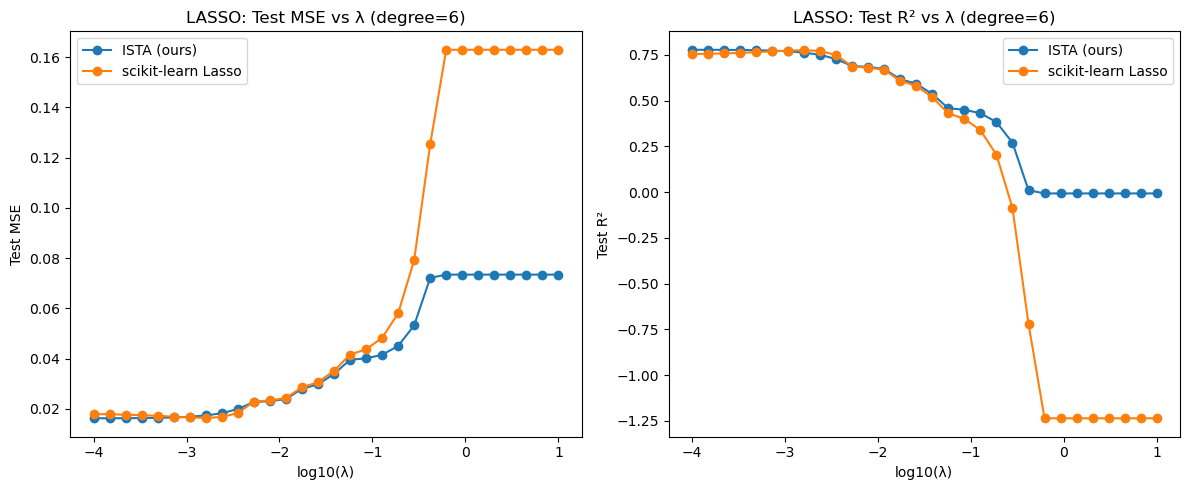

In [133]:
from sklearn.linear_model import Lasso

def run_lasso_sweep(degree=10, lambdas=np.logspace(-4, 1, 30)):
    # build design matrices, then (optionally) standardize inside lasso_ista
    X_train = design_matrix(x_train_scaled, degree)
    X_test  = design_matrix(x_test_scaled,  degree)

    # containers
    mse_ista, r2_ista = [], []
    mse_skl,  r2_skl  = [], []

    # fit across λ
    for lam in lambdas:
        # our ISTA
        theta, hist, Xtr_used = lasso_ista(X_train, y_train, lam=lam, max_iters=2000, tol=1e-8, standardize_cols=True)
        Xtr = X_train.copy()
        mu = Xtr[:,1:].mean(axis=0)
        sd = Xtr[:,1:].std(axis=0) + 1e-12
        Xte_used = X_test.copy()
        Xte_used[:,1:] = (Xte_used[:,1:] - mu) / sd

        yhat_te = Xte_used @ theta
        mse_ista.append(mse(y_test, yhat_te))
        r2_ista.append(r2_value(y_test, yhat_te))

        # scikit-learn Lasso (fit_intercept=False to match our intercept column)
        alpha = lam / 2.0
        clf = Lasso(alpha=alpha, fit_intercept=False, max_iter=100000, tol=1e-8)
        # scale *the same way* as ISTA for fair comparison
        clf.fit(Xtr_used, y_train)
        yhat_te_skl = clf.predict(Xte_used)
        mse_skl.append(mse(y_test, yhat_te_skl))
        r2_skl.append(r2_value(y_test, yhat_te_skl))

    return {"lambdas": lambdas,
            "ista": {"mse": np.array(mse_ista), "r2": np.array(r2_ista)},
            "skl":  {"mse": np.array(mse_skl),  "r2": np.array(r2_skl)}}

deg = 6
res_e = run_lasso_sweep(degree=deg)

# --- Plot: Test MSE / R² vs λ (ours vs scikit-learn) ---
import matplotlib.pyplot as plt

lamlog = np.log10(res_e["lambdas"])

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(lamlog, res_e["ista"]["mse"], 'o-', label='ISTA (ours)')
plt.plot(lamlog, res_e["skl"]["mse"],  'o-', label='scikit-learn Lasso')
plt.xlabel("log10(λ)"); plt.ylabel("Test MSE")
plt.title(f"LASSO: Test MSE vs λ (degree={deg})")
plt.legend()

plt.subplot(1,2,2)
plt.plot(lamlog, res_e["ista"]["r2"], 'o-', label='ISTA (ours)')
plt.plot(lamlog, res_e["skl"]["r2"],  'o-', label='scikit-learn Lasso')
plt.xlabel("log10(λ)"); plt.ylabel("Test R²")
plt.title(f"LASSO: Test R² vs λ (degree={deg})")
plt.legend()
plt.tight_layout(); plt.show()


Caption:

Figure Lasso: Test MSE (left) and R^2 (right) vs log10($\lambda$) for LASSO with polynomial degree 10. Results from our proximal gradient (ISTA) solver align closely with scikit-learn’s Lasso. Both methods achieve low error for small $\lambda$, but as regularization strengthens, coefficients are driven to zero, leading to increasing test MSE and decreasing R^2.

Part (e): LASSO via Proximal Gradient and Comparison with scikit-learn
We implemented LASSO using proximal gradient descent (ISTA) with soft-thresholding and compared the results against scikit-learn’s Lasso. Figure Lasso shows the test MSE and R^2 as a function of $\lambda$ for polynomial degree 10. Both implementations display the same qualitative behavior: for small $\lambda$, LASSO recovers a near-OLS solution with low bias but higher variance, resulting in strong predictive accuracy. As $\lambda$ increases, both methods gradually shrink coefficients, leading to higher bias but lower variance. At very large $\lambda$, the models collapse towards zero coefficients, causing MSE to rise and R^2 to drop sharply below zero. Our ISTA implementation tracks scikit-learn’s results closely, with small deviations at larger $\lambda$ due to differences in stopping tolerance and scaling conventions. Overall, the comparison validates the correctness of our proximal gradient approach while highlighting LASSO’s key property of driving coefficients exactly to zero, in contrast to Ridge from Part (b) which only shrinks them.

### Part f: Stochastic Gradient Descent

We first define functions for Stochastic Gradient Descent. We will be working with 2 main methods of Stochastic Gradient Descent, which are Minibatch Gradient Descent, with and without placement. We will also ADAM for the learning rate.

In [143]:
import numpy as np

def adam_ols_minibatch_v1(
    X, y,
    alpha=1e-2,           # Adam step size
    beta1=0.9, beta2=0.999, eps=1e-8,
    batch_size=32,
    epochs=50,
    steps_per_epoch=None,  
    grad_tol=1e-8,
    theta0=None,
    weight_decay=0.0,     
    seed=None
):
    n, p = X.shape
    rng = np.random.default_rng(seed)
    theta = np.zeros(p) if theta0 is None else theta0.copy()
    m = np.zeros_like(theta)
    v = np.zeros_like(theta)
    t = 0

    if steps_per_epoch is None:
        steps_per_epoch = max(1, n // max(1, batch_size))

    history = {"loss": [], "grad_norm": []}

    for _ in range(epochs):
        for _ in range(steps_per_epoch):
            idx = rng.choice(n, size=batch_size, replace=True)  # with replacement
            Xb, yb = X[idx], y[idx]

            rb   = Xb @ theta - yb
            grad = (2.0 / batch_size) * (Xb.T @ rb)

            if weight_decay:
                theta *= (1 - alpha * weight_decay)

            t += 1
            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * (grad * grad)
            mhat = m / (1 - beta1**t)
            vhat = v / (1 - beta2**t)
            theta -= alpha * mhat / (np.sqrt(vhat) + eps)

        r_full = X @ theta - y
        loss_full = (r_full @ r_full) / n
        grad_full = (2.0 / n) * (X.T @ r_full)
        history["loss"].append(loss_full)
        history["grad_norm"].append(np.linalg.norm(grad_full))
        if np.linalg.norm(grad_full) <= grad_tol:
            break

    return theta, history


In [144]:
import numpy as np
import math

def adam_ols_minibatch_v2(
    X, y,
    alpha=1e-2,           
    beta1=0.9, beta2=0.999, eps=1e-8,
    batch_size=32,
    epochs=50,
    grad_tol=1e-8,
    theta0=None,
    weight_decay=0.0,    
    seed=None
):
    n, p = X.shape
    rng = np.random.default_rng(seed)
    theta = np.zeros(p) if theta0 is None else theta0.copy()
    m = np.zeros_like(theta)
    v = np.zeros_like(theta)
    t = 0

    history = {"loss": [], "grad_norm": []}
    steps_per_epoch = math.ceil(n / max(1, batch_size))

    for _ in range(epochs):
        perm = rng.permutation(n) #shuffle once per epoch

        for s in range(steps_per_epoch):
            start = s * batch_size
            end   = min((s + 1) * batch_size, n)
            idx   = perm[start:end]

            Xb, yb = X[idx], y[idx]
            rb   = Xb @ theta - yb
            grad = (2.0 / len(idx)) * (Xb.T @ rb)

            if weight_decay:
                theta *= (1 - alpha * weight_decay)

            t += 1
            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * (grad * grad)
            mhat = m / (1 - beta1**t)
            vhat = v / (1 - beta2**t)
            theta -= alpha * mhat / (np.sqrt(vhat) + eps)

        r_full = X @ theta - y
        loss_full = (r_full @ r_full) / n
        grad_full = (2.0 / n) * (X.T @ r_full)
        gnorm = np.linalg.norm(grad_full)
        history["loss"].append(loss_full)
        history["grad_norm"].append(gnorm)
        if gnorm <= grad_tol:
            break

    return theta, history


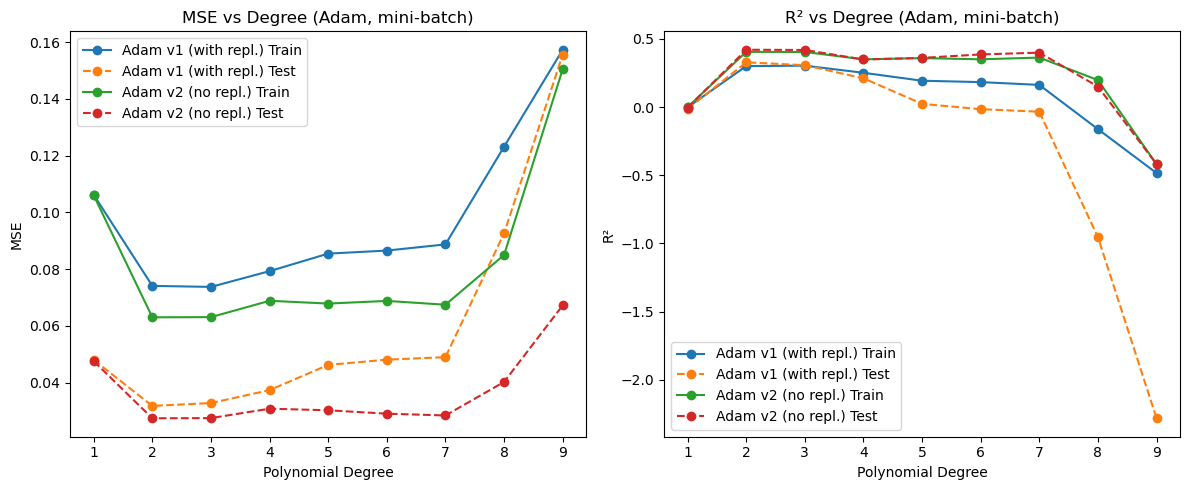

In [151]:
import numpy as np
import matplotlib.pyplot as plt

degrees     = range(1, 10)
grad_tol    = 1e-8
alpha_adam  = 1e-2      
batch_size  = 32
epochs      = 20

methods = {
    "Adam v1 (with repl.)": lambda X, y, theta0: adam_ols_minibatch_v1(
        X, y,
        alpha=alpha_adam,
        beta1=0.9, beta2=0.999, eps=1e-8,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=None,  
        grad_tol=grad_tol,
        theta0=theta0,
        weight_decay=0.0,    
        seed=0
    ),
    "Adam v2 (no repl.)": lambda X, y, theta0: adam_ols_minibatch_v2(
        X, y,
        alpha=alpha_adam,
        beta1=0.9, beta2=0.999, eps=1e-8,
        batch_size=batch_size,
        epochs=epochs,
        grad_tol=grad_tol,
        theta0=theta0,
        weight_decay=0.0,
        seed=0
    ),
}

results = {name: {"mse_train": [], "mse_test": [], "r2_train": [], "r2_test": []}
           for name in methods}

for d in degrees:
    X_train = design_matrix(x_train_scaled, d)
    X_test  = design_matrix(x_test_scaled,  d)
    theta0  = np.zeros(X_train.shape[1])  

    for name, fit in methods.items():
        beta, _ = fit(X_train, y_train, theta0)
        ytr_hat = predict(X_train, beta)
        yte_hat = predict(X_test,  beta)

        results[name]["mse_train"].append(mse(y_train, ytr_hat))
        results[name]["mse_test"].append(mse(y_test,  yte_hat))
        results[name]["r2_train"].append(r2_value(y_train, ytr_hat))
        results[name]["r2_test"].append(r2_value(y_test,  yte_hat))

# ---- Plots ----
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
for name in methods:
    plt.plot(degrees, results[name]["mse_train"], 'o-', label=f'{name} Train')
    plt.plot(degrees, results[name]["mse_test"],  'o--', label=f'{name} Test')
plt.xlabel("Polynomial Degree"); plt.ylabel("MSE")
plt.title("MSE vs Degree (Adam, mini-batch)")
plt.legend()

plt.subplot(1,2,2)
for name in methods:
    plt.plot(degrees, results[name]["r2_train"], 'o-', label=f'{name} Train')
    plt.plot(degrees, results[name]["r2_test"],  'o--', label=f'{name} Test')
plt.xlabel("Polynomial Degree"); plt.ylabel("R²")
plt.title("R² vs Degree (Adam, mini-batch)")
plt.legend(); plt.tight_layout(); plt.show()


The figure above shows the results for Stochastic Gradient Descent with ADAM and number of epochs = 20, iterating over the number of Polynomial Degrees. The results are rather similar to plain gradient descent, where at high degrees the test error increases significantly. Furthermore, SGD V2 seems to perform better than V1. This is because in V1 we sample batches with replacement and the same data can be seen multiple times in an epoch while others are skipped. As a result, the mini-batch gradients of V2 have lower variance, and the coverage is balanced, leading to better convergence


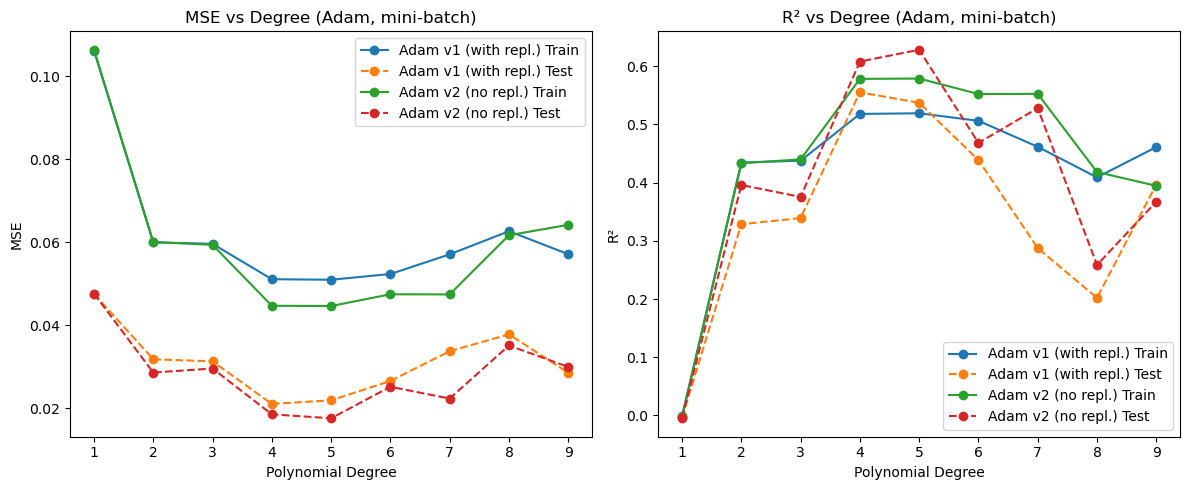

In [152]:
import numpy as np
import matplotlib.pyplot as plt

degrees     = range(1, 10)
grad_tol    = 1e-8
alpha_adam  = 1e-2     
batch_size  = 32
epochs      = 50   

methods = {
    "Adam v1 (with repl.)": lambda X, y, theta0: adam_ols_minibatch_v1(
        X, y,
        alpha=alpha_adam,
        beta1=0.9, beta2=0.999, eps=1e-8,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=None,        
        grad_tol=grad_tol,
        theta0=theta0,
        weight_decay=0.0,           
        seed=0
    ),
    "Adam v2 (no repl.)": lambda X, y, theta0: adam_ols_minibatch_v2(
        X, y,
        alpha=alpha_adam,
        beta1=0.9, beta2=0.999, eps=1e-8,
        batch_size=batch_size,
        epochs=epochs,
        grad_tol=grad_tol,
        theta0=theta0,
        weight_decay=0.0,
        seed=0
    ),
}

results = {name: {"mse_train": [], "mse_test": [], "r2_train": [], "r2_test": []}
           for name in methods}

for d in degrees:
    X_train = design_matrix(x_train_scaled, d)
    X_test  = design_matrix(x_test_scaled,  d)
    theta0  = np.zeros(X_train.shape[1])   # same init for fairness

    for name, fit in methods.items():
        beta, _ = fit(X_train, y_train, theta0)
        ytr_hat = predict(X_train, beta)
        yte_hat = predict(X_test,  beta)

        results[name]["mse_train"].append(mse(y_train, ytr_hat))
        results[name]["mse_test"].append(mse(y_test,  yte_hat))
        results[name]["r2_train"].append(r2_value(y_train, ytr_hat))
        results[name]["r2_test"].append(r2_value(y_test,  yte_hat))

# ---- Plots ----
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
for name in methods:
    plt.plot(degrees, results[name]["mse_train"], 'o-', label=f'{name} Train')
    plt.plot(degrees, results[name]["mse_test"],  'o--', label=f'{name} Test')
plt.xlabel("Polynomial Degree"); plt.ylabel("MSE"); plt.title("MSE vs Degree (Adam, mini-batch)")
plt.legend()

plt.subplot(1,2,2)
for name in methods:
    plt.plot(degrees, results[name]["r2_train"], 'o-', label=f'{name} Train')
    plt.plot(degrees, results[name]["r2_test"],  'o--', label=f'{name} Test')
plt.xlabel("Polynomial Degree"); plt.ylabel("R²"); plt.title("R² vs Degree (Adam, mini-batch)")
plt.legend(); plt.tight_layout(); plt.show()


The figure above shows the same Gradient descent but with a larger number of epochs. With a higher number of epochs, there is more parameter updates and we are closer to the ols minimizer, and we can see that the difference in test MSE is much lesser between SGD V1 and V2

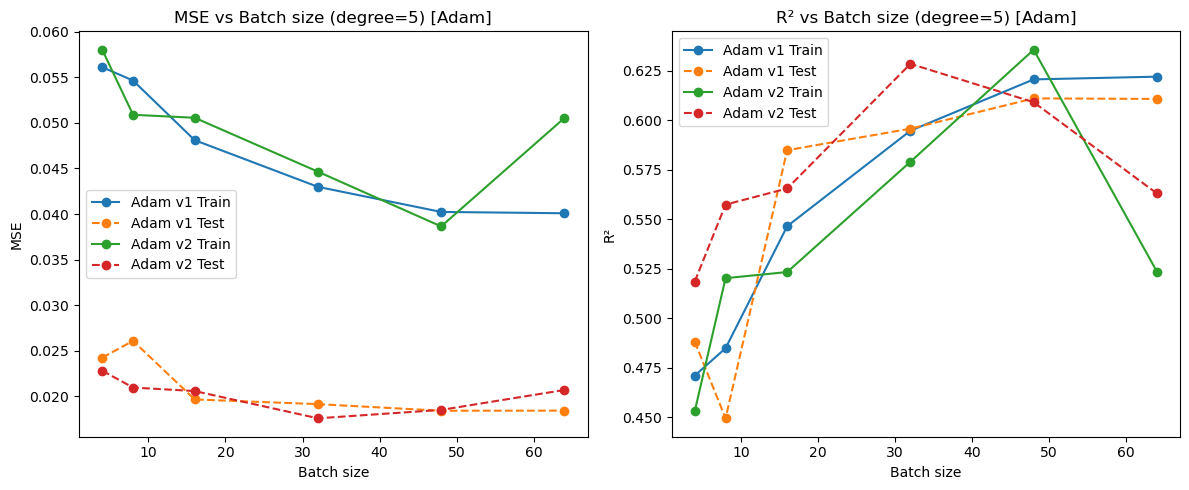

In [153]:
import numpy as np
import matplotlib.pyplot as plt
import math

# --- Settings ---
degree      = 5
grad_tol    = 1e-8
alpha_adam  = 1e-2        
weight_decay = 0.0       
epochs_ref  = 50          
b_ref       = 32          
candidate_batch_sizes = [4, 8, 16, 32, 48, 64, 96, 128, 256]

# --- Build design matrices once ---
X_train = design_matrix(x_train_scaled, degree)
X_test  = design_matrix(x_test_scaled,  degree)
n = X_train.shape[0]
batch_sizes = [b for b in candidate_batch_sizes if 1 <= b <= n]

# reference total updates
U_ref = epochs_ref * math.ceil(n / b_ref)

mse_train_v1, mse_test_v1, r2_train_v1, r2_test_v1 = [], [], [], []
mse_train_v2, mse_test_v2, r2_train_v2, r2_test_v2 = [], [], [], []

for bsz in batch_sizes:
    theta0 = np.zeros(X_train.shape[1])

    steps_per_epoch = math.ceil(n / bsz)
    epochs_b = max(1, math.ceil(U_ref / steps_per_epoch))


    alpha_b = alpha_adam

    beta_v1, _ = adam_ols_minibatch_v1(
        X_train, y_train,
        alpha=alpha_b, beta1=0.9, beta2=0.999, eps=1e-8,
        batch_size=bsz,
        epochs=epochs_b,
        steps_per_epoch=steps_per_epoch,  # make v1 comparable to v2
        grad_tol=grad_tol,
        theta0=theta0,
        weight_decay=weight_decay,
        seed=0
    )
    ytr = predict(X_train, beta_v1); yte = predict(X_test, beta_v1)
    mse_train_v1.append(mse(y_train, ytr)); mse_test_v1.append(mse(y_test, yte))
    r2_train_v1.append(r2_value(y_train, ytr)); r2_test_v1.append(r2_value(y_test, yte))

    beta_v2, _ = adam_ols_minibatch_v2(
        X_train, y_train,
        alpha=alpha_b, beta1=0.9, beta2=0.999, eps=1e-8,
        batch_size=bsz,
        epochs=epochs_b,
        grad_tol=grad_tol,
        theta0=theta0,
        weight_decay=weight_decay,
        seed=0
    )
    ytr = predict(X_train, beta_v2); yte = predict(X_test, beta_v2)
    mse_train_v2.append(mse(y_train, ytr)); mse_test_v2.append(mse(y_test, yte))
    r2_train_v2.append(r2_value(y_train, ytr)); r2_test_v2.append(r2_value(y_test, yte))

# --- Plots ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(batch_sizes, mse_train_v1, 'o-', label='Adam v1 Train')
plt.plot(batch_sizes, mse_test_v1,  'o--', label='Adam v1 Test')
plt.plot(batch_sizes, mse_train_v2, 'o-', label='Adam v2 Train')
plt.plot(batch_sizes, mse_test_v2,  'o--', label='Adam v2 Test')
plt.xlabel("Batch size"); plt.ylabel("MSE"); plt.title(f"MSE vs Batch size (degree={degree}) [Adam]")
plt.legend()

plt.subplot(1,2,2)
plt.plot(batch_sizes, r2_train_v1, 'o-', label='Adam v1 Train')
plt.plot(batch_sizes, r2_test_v1,  'o--', label='Adam v1 Test')
plt.plot(batch_sizes, r2_train_v2, 'o-', label='Adam v2 Train')
plt.plot(batch_sizes, r2_test_v2,  'o--', label='Adam v2 Test')
plt.xlabel("Batch size"); plt.ylabel("R²"); plt.title(f"R² vs Batch size (degree={degree}) [Adam]")
plt.legend(); plt.tight_layout(); plt.show()


The figure above shows the results for Stochastic Gradient Descent with a fixed learning rate, iterating over Batch Size with a fixed polynomial degree. We do not fix the number of epochs since for larger batch sizes, the parameters is updated less for a fixed number of epochs. So we increase the number of epochs as the batch size increases. The test MSE improves as the number of batch size increases initially, before it worsens. This is because at small batch sizes, there is too much noise under training. While at larger batch sizes, we lose the stochastic regularization.

### Part g: Resampling with Bootstrapping


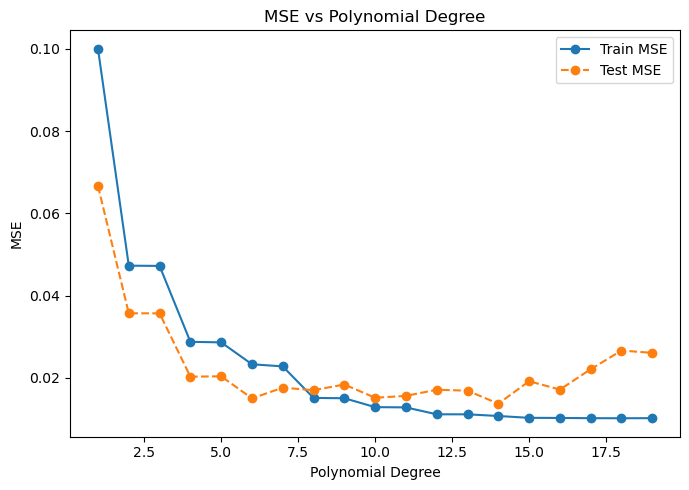

In [88]:
import numpy as np
import matplotlib.pyplot as plt

n_points = 100
x = np.linspace(-1, 1, n_points).reshape(-1, 1)

y_true = runge_function(x).ravel()

y = runge_noisy(x, noise = 0.1).ravel()

# split & scale as before
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled  = scaler.transform(x_test)

degrees = range(1, 20)
mse_train, mse_test = [], []

for d in degrees:
    X_train = design_matrix(x_train_scaled, d)
    X_test  = design_matrix(x_test_scaled,  d)

    beta = ols_fit(X_train, y_train)

    y_train_pred = predict(X_train, beta)
    y_test_pred  = predict(X_test,  beta)

    mse_train.append(mse(y_train, y_train_pred))
    mse_test.append(mse(y_test,  y_test_pred))

plt.figure(figsize=(7,5))
plt.plot(degrees, mse_train, 'o-', label="Train MSE")
plt.plot(degrees, mse_test,  'o--', label="Test MSE")
plt.xlabel("Polynomial Degree")
plt.ylabel("MSE")
plt.title("MSE vs Polynomial Degree")
plt.legend()
plt.tight_layout()
plt.show()


The figure below imitates Fig. 2.11 of Hastie, Tibshirani, and Friedman. It is a U shaped curve representing high test error at low numbers of polynomial degree, due to high bias. The low variance at low polynomial degrees is seen by the Train and Test MSE being close. At high polynomial degrees, There is high variance resulting in higher Test MSE, although Train MSE continues decreasing. The Test MSE is lowest at some intermediate polynomial degree where there is low variance and low bias.

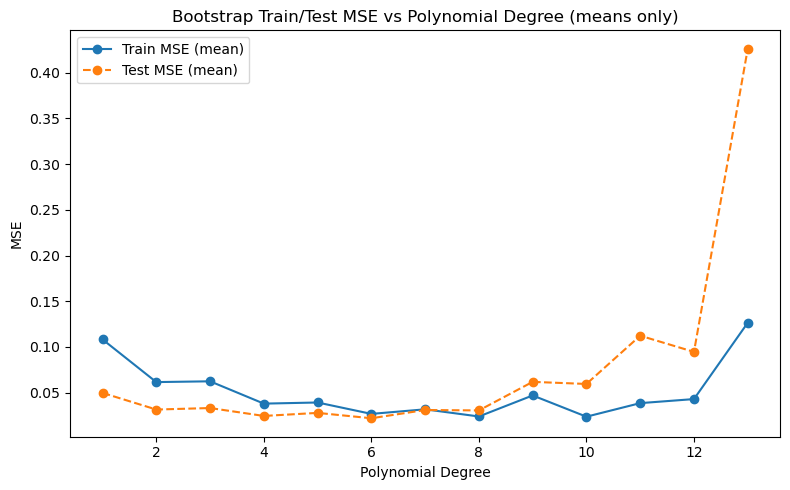

In [154]:
import numpy as np
import matplotlib.pyplot as plt


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled  = scaler.transform(x_test)
degrees = range(1, 14)
B = 200                          # number of bootstrap replicates
rng = np.random.default_rng(0)   # reproducible

# ----- precompute design matrices for speed -----
X_train_list = [design_matrix(x_train_scaled, d) for d in degrees]
X_test_list  = [design_matrix(x_test_scaled,  d) for d in degrees]

n_train = X_train_list[0].shape[0]
mse_train_boot = np.zeros((B, len(degrees)))
mse_test_boot  = np.zeros((B, len(degrees)))

for b in range(B):
    # sample training rows WITH replacement
    idx = rng.integers(0, n_train, size=n_train)
    yb  = y_train[idx]

    for j, _ in enumerate(degrees):
        Xb = X_train_list[j][idx]          # bootstrap-resampled design matrix

        # fit on bootstrap sample
        beta_b = ols_fit(Xb, yb)

        # evaluate TRAIN MSE on the FULL training set (not just the resample)
        ytr_pred_full = predict(X_train_list[j], beta_b)
        mse_train_boot[b, j] = mse(y_train, ytr_pred_full)

        # evaluate TEST MSE on the fixed test set
        yte_pred = predict(X_test_list[j], beta_b)
        mse_test_boot[b, j] = mse(y_test, yte_pred)

# ----- summarize across bootstraps (means only) -----
train_mean = mse_train_boot.mean(axis=0)
test_mean  = mse_test_boot.mean(axis=0)

# ----- plot (means only) -----
plt.figure(figsize=(8,5))
plt.plot(list(degrees), train_mean, 'o-', label='Train MSE (mean)')
plt.plot(list(degrees), test_mean,  'o--', label='Test MSE (mean)')
plt.xlabel("Polynomial Degree")
plt.ylabel("MSE")
plt.title("Bootstrap Train/Test MSE vs Polynomial Degree (means only)")
plt.legend()
plt.tight_layout()
plt.show()


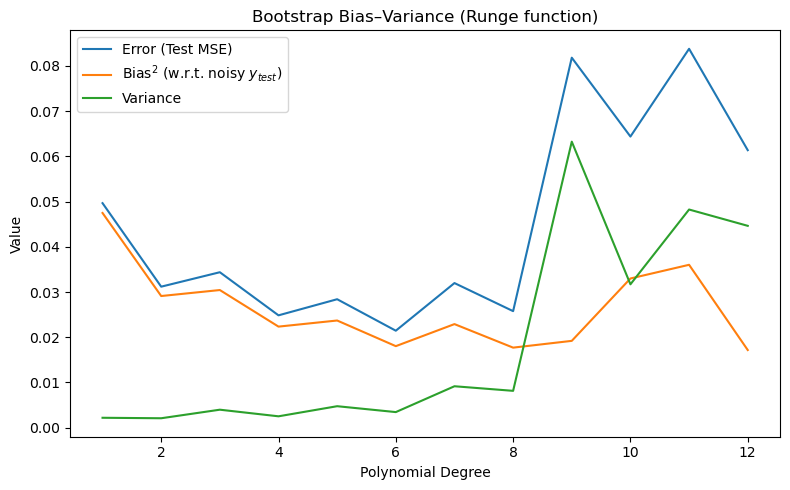

In [159]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

n_boostraps = 100  
maxdegree = 12

error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)      
variance = np.zeros(maxdegree)
polydeg = np.arange(1, maxdegree+1)

rng = np.random.default_rng(0)
n_train = x_train_scaled.shape[0]
n_test = x_test_scaled.shape[0]

for idx, degree in enumerate(polydeg):
    X_train = design_matrix(x_train_scaled, degree)
    X_test = design_matrix(x_test_scaled, degree)

    y_pred = np.empty((n_test, n_boostraps))

    for b in range(n_boostraps):
        boot_idx = rng.integers(0, n_train, size=n_train)  # WITH replacement
        beta_b = ols_fit(X_train[boot_idx], y_train[boot_idx])
        y_pred[:, b] = predict(X_test, beta_b).ravel()

    mu = y_pred.mean(axis=1, keepdims=True)             
    var = y_pred.var(axis=1, ddof=1, keepdims=True)      

    variance[idx] = var.mean()
    error[idx] = np.mean((y_test.reshape(-1,1) - y_pred)**2) 
    bias[idx] = np.mean((y_test.reshape(-1,1) - mu)**2)      

# --- Plot (like your example) ---
plt.figure(figsize=(8,5))
plt.plot(polydeg, error, label='Error (Test MSE)')
plt.plot(polydeg, bias, label='Bias$^2$ (w.r.t. noisy $y_{test}$)')
plt.plot(polydeg, variance, label='Variance')
plt.xlabel('Polynomial Degree')
plt.ylabel('Value')
plt.title('Bootstrap Bias–Variance (Runge function)')
plt.legend()
plt.tight_layout()
plt.show()


The figure below shows the Bias Variance Trade-off for the Runge function using Bootstrap as a resampling method. We lower the maximum degree to 12 for easier analysis. At low degrees, the model is too rigid to learn Runge's Curvature and underfits, with a large bias that dominates the Test MSE. At the same time, variance is small since different bootstrap fits look alike. As the model complexity increases, the model captures Runge's curvature better and bias decreases. At the same time, variance increases slightly and the Test error decreases. This intermediate complexity is where Test MSE is the lowest. At higher degrees, The model starts overfitting, and different bootstrap fits differ largely. As a result, while bias is low, variance increases and domaintes the test MSE, which increases.

### part h:

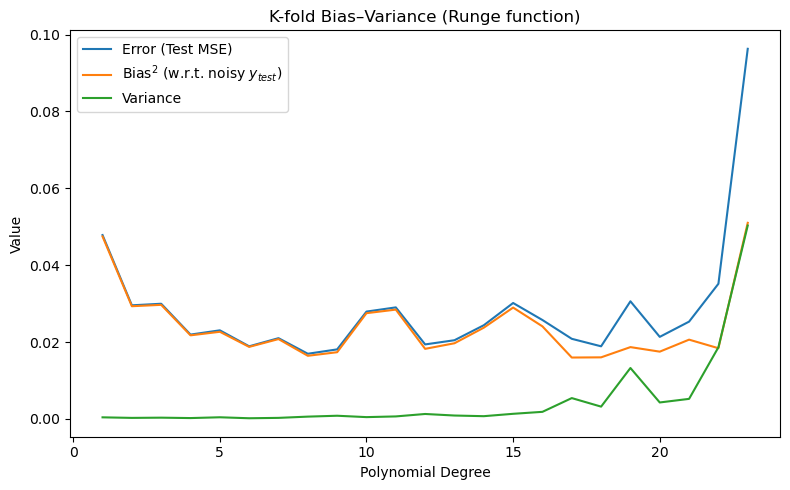

In [163]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

maxdegree = 23        
polydeg   = np.arange(1, maxdegree+1)
k         = 10                

error    = np.zeros(maxdegree)
bias     = np.zeros(maxdegree)     
variance = np.zeros(maxdegree)

kf = KFold(n_splits=k, shuffle=True, random_state=0)

n_test = x_test.shape[0]

for idx, degree in enumerate(polydeg):
    y_pred_test = np.empty((n_test, k))
    col = 0

    for tr_idx, val_idx in kf.split(x_train):
        x_tr, y_tr = x_train[tr_idx], y_train[tr_idx]

        scaler = StandardScaler()
        x_tr_s = scaler.fit_transform(x_tr)
        x_te_s = scaler.transform(x_test)

        X_tr = design_matrix(x_tr_s, degree)
        X_te = design_matrix(x_te_s, degree)

        beta = ols_fit(X_tr, y_tr)
        y_pred_test[:, col] = predict(X_te, beta).ravel()
        col += 1

    mu  = y_pred_test.mean(axis=1, keepdims=True)           
    var = y_pred_test.var(axis=1, ddof=1, keepdims=True)    

    variance[idx] = var.mean()
    error[idx]    = np.mean((y_test.reshape(-1,1) - y_pred_test)**2)
    bias[idx]     = np.mean((y_test.reshape(-1,1) - mu)**2)


# --- plot (same style as your bootstrap figure) ---
plt.figure(figsize=(8,5))
plt.plot(polydeg, error,    label='Error (Test MSE)')
plt.plot(polydeg, bias,     label='Bias$^2$ (w.r.t. noisy $y_{test}$)')
plt.plot(polydeg, variance, label='Variance')
plt.xlabel('Polynomial Degree'); plt.ylabel('Value')
plt.title('K-fold Bias–Variance (Runge function)')
plt.legend(); plt.tight_layout(); plt.show()


The figure above shows the Bias Variance Tradeoff using KfoldCV as a resampling method. The results are rather similar, but The Variance in K-foldCV tends to be more stable and only blows up at much higher polynomial degrees. The reason for this is because K-fold trains each model on more distinct data points as compared to bootstrap, and with more unique data for each fit, the model fluctuates less leading to lower variance.


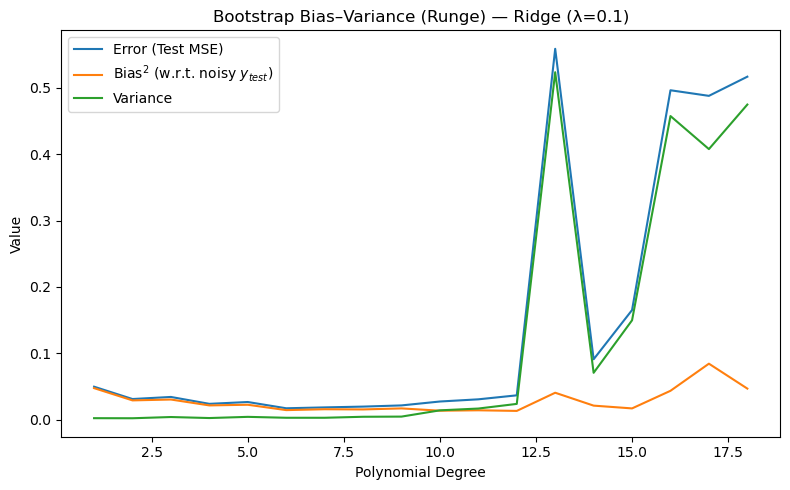

In [166]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


n_boostraps = 100   
maxdegree   = 18 
lam         = 0.1  

error    = np.zeros(maxdegree)
bias     = np.zeros(maxdegree)      
variance = np.zeros(maxdegree)
polydeg  = np.arange(1, maxdegree+1)

rng = np.random.default_rng(0)
n_train = x_train_scaled.shape[0]
n_test  = x_test_scaled.shape[0]

for idx, degree in enumerate(polydeg):
    X_train = design_matrix(x_train_scaled, degree)
    X_test  = design_matrix(x_test_scaled,  degree)

    y_pred = np.empty((n_test, n_boostraps))

    for b in range(n_boostraps):
        boot_idx = rng.integers(0, n_train, size=n_train)
        beta_b = ridge_reg(X_train[boot_idx], y_train[boot_idx], lam)
        y_pred[:, b] = predict(X_test, beta_b).ravel()

    mu  = y_pred.mean(axis=1, keepdims=True)              
    var = y_pred.var(axis=1, ddof=1, keepdims=True)       


    variance[idx] = var.mean()
    error[idx]    = np.mean((y_test.reshape(-1,1) - y_pred)**2)  
    bias[idx]     = np.mean((y_test.reshape(-1,1) - mu)**2)      

# --- Plot (same style) ---
plt.figure(figsize=(8,5))
plt.plot(polydeg, error,    label='Error (Test MSE)')
plt.plot(polydeg, bias,     label='Bias$^2$ (w.r.t. noisy $y_{test}$)')
plt.plot(polydeg, variance, label='Variance')
plt.xlabel('Polynomial Degree')
plt.ylabel('Value')
plt.title(f'Bootstrap Bias–Variance (Runge) — Ridge (λ={lam})')
plt.legend()
plt.tight_layout()
plt.show()


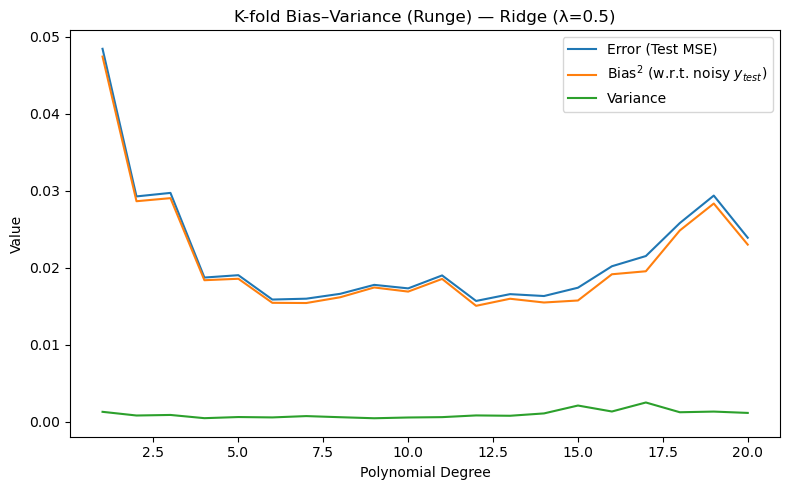

In [167]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler


maxdegree = 20            
polydeg   = np.arange(1, maxdegree+1)
k         = 5                  
lam       = 0.5            

error    = np.zeros(maxdegree)
bias     = np.zeros(maxdegree)      
variance = np.zeros(maxdegree)

kf = KFold(n_splits=k, shuffle=True, random_state=0)
n_test = x_test.shape[0]

for idx, degree in enumerate(polydeg):
    y_pred_test = np.empty((n_test, k))
    col = 0

    for tr_idx, val_idx in kf.split(x_train):
        x_tr, y_tr = x_train[tr_idx], y_train[tr_idx]

        scaler = StandardScaler()
        x_tr_s = scaler.fit_transform(x_tr)
        x_te_s = scaler.transform(x_test)
        
        X_tr = design_matrix(x_tr_s, degree)
        X_te = design_matrix(x_te_s, degree)

        beta = ridge_reg(X_tr, y_tr, lam)
        y_pred_test[:, col] = predict(X_te, beta).ravel()
        col += 1

    mu  = y_pred_test.mean(axis=1, keepdims=True)          
    var = y_pred_test.var(axis=1, ddof=1, keepdims=True)    

    variance[idx] = var.mean()
    error[idx]    = np.mean((y_test.reshape(-1,1) - y_pred_test)**2)
    bias[idx]     = np.mean((y_test.reshape(-1,1) - mu)**2)

plt.figure(figsize=(8,5))
plt.plot(polydeg, error,    label='Error (Test MSE)')
plt.plot(polydeg, bias,     label='Bias$^2$ (w.r.t. noisy $y_{test}$)')
plt.plot(polydeg, variance, label='Variance')
plt.xlabel('Polynomial Degree')
plt.ylabel('Value')
plt.title(f'K-fold Bias–Variance (Runge) — Ridge (λ={lam})')
plt.legend()
plt.tight_layout()
plt.show()


Performing Bias Variane Trade-off analysis using Ridge, we get a rather similar result. However, because Ridge shrinks coefficient towards 0, predictions fluctuate much less and the variance rises more slowly. With Lasso Regression, the same can be observed, except that the Variance blows up at much higher degrees compared to Ridge. This is largely because Lasso zeroes out many higher order terms. As a result, we also see that the bias increases for Lasso as well, 

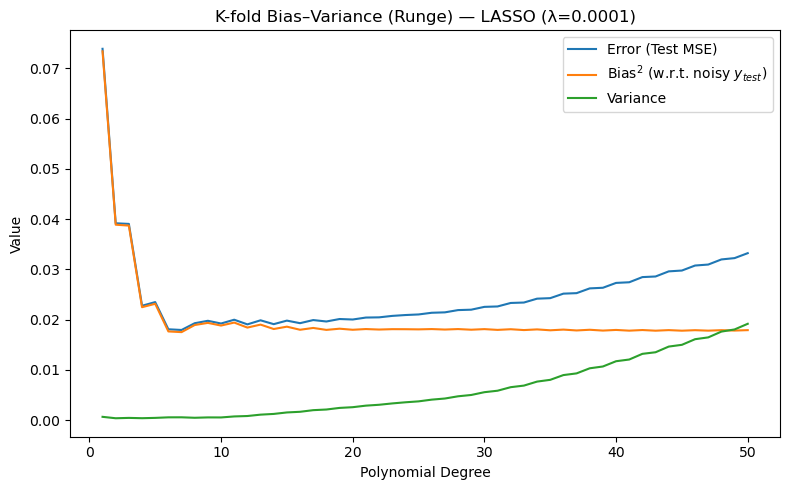

In [139]:
# K-fold Bias–Variance for the Runge function using LASSO (ISTA)
# Uses your lasso_ista() as given. We standardize the design matrix columns (j>=1) per-fold
# and call lasso_ista(..., standardize_cols=False) to avoid double-standardizing.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# --- Settings ---
maxdegree = 50# degrees 1..20
polydeg   = np.arange(1, maxdegree+1)
k         = 5                  # KFold splits
lam       = 0.0001              # LASSO strength (try 1e-3 .. 1e-1)

error    = np.zeros(maxdegree)
bias     = np.zeros(maxdegree)      # bias^2 w.r.t. noisy y_test
variance = np.zeros(maxdegree)

kf = KFold(n_splits=k, shuffle=True, random_state=0)
n_test = x_test.shape[0]

for idx, degree in enumerate(polydeg):
    # collect predictions on the SAME fixed test set from each fold-trained model
    y_pred_test = np.empty((n_test, k))
    col = 0

    for tr_idx, val_idx in kf.split(x_train):
        x_tr, y_tr = x_train[tr_idx], y_train[tr_idx]

        # 1) Scale x INSIDE the fold (fit on fold-train), apply to TEST set
        scaler = StandardScaler()
        x_tr_s = scaler.fit_transform(x_tr)
        x_te_s = scaler.transform(x_test)

        # 2) Build polynomial design matrices
        X_tr_raw = design_matrix(x_tr_s, degree)
        X_te_raw = design_matrix(x_te_s, degree)

        # 3) Standardize design-matrix columns 1..p-1 (leave intercept unscaled)
        mu = X_tr_raw[:, 1:].mean(axis=0)
        sd = X_tr_raw[:, 1:].std(axis=0) + 1e-12

        X_tr = X_tr_raw.copy()
        X_te = X_te_raw.copy()
        if X_tr.shape[1] > 1:
            X_tr[:, 1:] = (X_tr[:, 1:] - mu) / sd
            X_te[:, 1:] = (X_te[:, 1:] - mu) / sd

        # 4) Fit LASSO via ISTA on the standardized design matrix (no extra standardization inside)
        theta, hist, _ = lasso_ista(X_tr, y_tr, lam=lam, max_iters=10000, tol=1e-8,
                                    theta0=None, standardize_cols=False)

        # 5) Predict on the FIXED test set for this fold-trained model
        y_pred_test[:, col] = (X_te @ theta).ravel()
        col += 1

    # moments across the k fold-trained models at each test point
    mu_pred  = y_pred_test.mean(axis=1, keepdims=True)           # E[yhat | x_test]
    var_pred = y_pred_test.var(axis=1, ddof=1, keepdims=True)    # Var[yhat | x_test]

    # aggregate over test points
    variance[idx] = var_pred.mean()
    error[idx]    = np.mean((y_test.reshape(-1,1) - y_pred_test)**2)
    bias[idx]     = np.mean((y_test.reshape(-1,1) - mu_pred)**2)

# --- Plot (same style as before) ---
plt.figure(figsize=(8,5))
plt.plot(polydeg, error,    label='Error (Test MSE)')
plt.plot(polydeg, bias,     label='Bias$^2$ (w.r.t. noisy $y_{test}$)')
plt.plot(polydeg, variance, label='Variance')
plt.xlabel('Polynomial Degree')
plt.ylabel('Value')
plt.title(f'K-fold Bias–Variance (Runge) — LASSO (λ={lam})')
plt.legend()
plt.tight_layout()
plt.show()


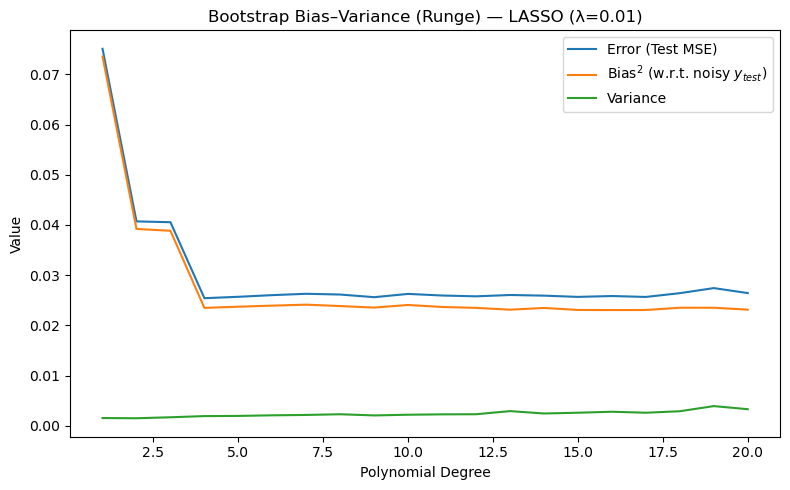

In [140]:
# Bootstrap Bias–Variance for the Runge function using LASSO (ISTA)
# Uses your lasso_ista() exactly as defined.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# --- Settings ---
maxdegree     = 20                  # degrees 1..20
polydeg       = np.arange(1, maxdegree+1)
n_bootstraps  = 200                 # number of bootstrap replicates
lam           = 1e-2                # LASSO strength (try 1e-3 .. 1e-1)

error    = np.zeros(maxdegree)
bias     = np.zeros(maxdegree)      # bias^2 w.r.t. noisy y_test
variance = np.zeros(maxdegree)

rng = np.random.default_rng(0)
n_train = x_train.shape[0]
n_test  = x_test.shape[0]

for idx, degree in enumerate(polydeg):
    # Collect predictions on the SAME fixed test set from each bootstrap-trained model
    y_pred_test = np.empty((n_test, n_bootstraps))

    for b in range(n_bootstraps):
        # 1) Sample train rows WITH replacement
        boot_idx = rng.integers(0, n_train, size=n_train)
        x_tr, y_tr = x_train[boot_idx], y_train[boot_idx]

        # 2) Scale x INSIDE the bootstrap sample; apply to TEST set
        scaler = StandardScaler()
        x_tr_s = scaler.fit_transform(x_tr)
        x_te_s = scaler.transform(x_test)

        # 3) Build polynomial design matrices
        X_tr_raw = design_matrix(x_tr_s, degree)
        X_te_raw = design_matrix(x_te_s, degree)

        # 4) Standardize design-matrix columns 1..p-1 (leave intercept unscaled)
        X_tr = X_tr_raw.copy()
        X_te = X_te_raw.copy()
        if X_tr.shape[1] > 1:
            mu = X_tr[:, 1:].mean(axis=0)
            sd = X_tr[:, 1:].std(axis=0) + 1e-12
            X_tr[:, 1:] = (X_tr[:, 1:] - mu) / sd
            X_te[:, 1:] = (X_te[:, 1:] - mu) / sd

        # 5) Fit LASSO via ISTA (no extra standardization inside)
        theta, hist, _ = lasso_ista(X_tr, y_tr, lam=lam,
                                    max_iters=10000, tol=1e-8,
                                    theta0=None, standardize_cols=False)

        # 6) Predict on the fixed test set for this bootstrap-trained model
        y_pred_test[:, b] = (X_te @ theta).ravel()

    # Moments across bootstrap models at each test point
    mu_pred  = y_pred_test.mean(axis=1, keepdims=True)           # E[yhat | x_test]
    var_pred = y_pred_test.var(axis=1, ddof=1, keepdims=True)    # Var[yhat | x_test]

    # Aggregate over test points
    variance[idx] = var_pred.mean()
    error[idx]    = np.mean((y_test.reshape(-1,1) - y_pred_test)**2)
    bias[idx]     = np.mean((y_test.reshape(-1,1) - mu_pred)**2)

# --- Plot (same style as your other figures) ---
plt.figure(figsize=(8,5))
plt.plot(polydeg, error,    label='Error (Test MSE)')
plt.plot(polydeg, bias,     label='Bias$^2$ (w.r.t. noisy $y_{test}$)')
plt.plot(polydeg, variance, label='Variance')
plt.xlabel('Polynomial Degree')
plt.ylabel('Value')
plt.title(f'Bootstrap Bias–Variance (Runge) — LASSO (λ={lam})')
plt.legend()
plt.tight_layout()
plt.show()
